# Importing the nessesary packages:

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
import math

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

basedir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/'
fitdir=basedir+'main_beam_fits/'
ymldir = basedir+'concat_config_files/'
pckldir = basedir+'flight_pickles/'
ampdir = basedir+'amplitude_corrections/'
beamdir = basedir+'2023_SpringSummer_products/'
tmpfitpath=basedir+'main_beam_fits/Coadded_2dGauss_With_Errors.npz'
avfitpath=basedir+'main_beam_fits/Averaged_2dGauss_and_Airy_Param.npz'

# Defining basic file reading functions

In [2]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='E':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

#sliceOrientation: h means this function is taking a horizontal slice, and v means this function is taking a vertical 
#slice. 
def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/beam_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

def readPickleFile (pol, freqInd): #write the documentation for this 
    picklefile = beamdir+'Beamcoadd_pol_'+pol+'_freq_'+str(good_freqs[freqInd])+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    return ptest 

def turnPickle (flight, freq):
    pol, pols, cpols, attn, fi = get_flightinfo(flight)
    print (pol,pols,cpols,attn,fi)
    with open(glob.glob(pckldir+'*'+flight+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on   
    print (gfitarr[fi])
    find=good_freqs[freq]
    beam1=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                     normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                     Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find)
    return beam1


In [3]:
################################################################################################
######## 1. Read in some particular frequency, polarization 2D co-added beam ################
################################################################################################

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']




['Averaged_2dGauss_and_Airy_Param.npz' 'Coadded_2dGauss_With_Errors.npz'
 'Coadded_2dGauss_and_Airy_Params.npz'
 'Coadded_2dGauss_and_Airy_Params_18mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_20mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_25mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_halfspace.npz'
 'FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Air

/tmp/ipykernel_31317/2940412915.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('gnuplot2')


In [4]:
# pick your polarization and frequency

print(good_freqs)
# ask why this where isn't working for me -- print(np.where(good_freqs == '561')[0])

# set which pol:
copoldir = 'E'
polsE = E_pols
polsN = N_pols
find = good_freqs[0]
f_intern = 0 # only one frequency per file, this is always 0
print(polsN)
print (freqs[good_freqs[94]])

for i in range (len(good_freqs)):
    print (good_freqs[i], i)

[538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 599, 630, 631, 633, 645, 676, 691, 692, 693, 696, 697, 698, 699, 700, 705, 707, 720, 768, 799, 807, 814, 845, 846, 848, 849, 850, 851, 854, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 871, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 887, 888, 889, 890, 891, 893, 894, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 935, 938]
[1, 3, 9, 11, 15]
448.046875
538 0
553 1
554 2
555 3
556 4
557 5
558 6
560 7
561 8
562 9
563 10
564 11
565 12
566 13
567 14
568 15
569 16
571 17
572 18
573 19
575 20
576 21
577 22
578 23
579 24
580 25
581 26
582 27
583 28
584 29
599 30
630 31
631 32
633 33
645 34
676 35
691 36
692 37
693 38
696 39
697 40
698 41
699 42
700 43
705 44
707 45
720 46
768 47
799 48
807 49
814 5

In [5]:



#calculating the Gaussian -- 

#This function calculates the value of a 2D gaussian with user fed parameters for every point in a list of x-y coordinates. 
# parameters: 
#     P- a vector with amp0, x00, xsig0, y00, ysig0, and bg 0
#     x_coords- array of x coordinates, 1D numpy array
#     y_coords- array of y coordinates, 1D numpy array
# returns: 
#     results- 1D numpy array, each entry is the gaussian value assocaited with the x and y coordinates at the same index in the respective y and x coordinate lists 
def gaussianResultArray (P, x_coords, y_coords):
    results = np.empty(x_coords.size)
    i = 0
    while i < x_coords.size:
        results[i] = fu.Gauss_2d_LC_func(P, x_coords[i], y_coords[i])
        i = i + 1
    return results

#This function graphs the 2D gaussian fit over a grid of specified x and y coordinates. The fit value is displayed by color. 
# parameters: 
#     P- a vector with amp0, x00, xsig0, y00, ysig0, and bg 0
#     x_coords- array of x coordinates, 1D numpy array
#     y_coords- array of y coordinates, 1D numpy array
# returns nothing 
def graphGaussianResults (P, x_coords, y_coords): 
    fig, ax1 = subplots(nrows=1, ncols=1, figsize = (10,10))
    c = gaussianResultArray(P,x_coords, y_coords)
    im1=ax1.scatter(x_coords, y_coords, c=c, vmin=0, vmax=1, s=30)
    ax1.set_xlim(-sz,sz)
    ax1.set_ylim(-sz,sz)
    ax1.set_xlabel("X Position m")
    ax1.set_ylabel("Y Position m")
    divider=make_axes_locatable(ax1)
    cax=divider.append_axes("right", size="3%", pad = 0.05)
    cbar=fig.colorbar(im1, cax=cax)
    ax1.set_title('Aproximation')
    tight_layout()
    
def getSliceGauss(gaussArray, ax):
    if ax == 'v':
        sliceIndexes = np.where((mbx < (0+3)) & (mbx> (0)))[0]
    else:
        sliceIndexes = np.where((mby<(0+3)) & (mby> (0)))[0]
    slicey = np.empty((3, sliceIndexes.size))
    slicey[0,:] = mbx[sliceIndexes]
    slicey[1,:] = mby[sliceIndexes]
    slicey[2,:] = gaussArray[sliceIndexes]
    return slicey


#restrict to specific small range --suffer suffer suffer--
def getAverageResiduals(gaussArray, initVArray, ch, x_coords, y_coords, polarizationStr, gooddata):
    if polarizationStr == 'N':
        chind = polsN[ch]
    else: 
        chind = polsE[ch] 
    valueArray=initVArray.V_LC_operation[:,:,0,chind].flatten()[gooddata]
    subArray = np.subtract(gaussArray[gooddata], valueArray)
    totSum = 0; 
    countCount = 0;
    #numpy sum 
    for i, chind in enumerate (subArray):
        if ((x_coords[gooddata][i] > -20) & (x_coords[gooddata][i] < 20) & (y_coords[gooddata][i] > -20) & (y_coords[gooddata][i] < 20)):
            totSum += subArray[i]
            countCount += 1;
    return (totSum / countCount)

def getResidualVarience (gaussArray, initVArray, ch, x_coords, y_coords, polarizationStr, gooddata):
    if polarizationStr == 'N':
        chind = polsN[ch]
    else: 
        chind = polsE[ch]
    valueArray=initVArray.V_LC_operation[:,:,0,chind].flatten()[gooddata]
    subArray = np.subtract(gaussArray[gooddata], valueArray)
    totSum = 0; 
    countCount = 0;
    #numpy sum 
    for i, chind in enumerate (subArray):
        if ((x_coords[gooddata][i] > -20) & (x_coords[gooddata][i] < 20) & (y_coords[gooddata][i] > -20) & (y_coords[gooddata][i] < 20)):
            totSum += subArray[i] ** 2
            countCount += 1;
    return (totSum / countCount)

def getResidualsSTDEV(gaussArray, initVArray, ch, x_coords, y_coords, polarizationStr, gooddata):
    if polarizationStr == 'N':
        chind = polsN[ch]
    else: 
        chind = polsE[ch]
    valueArray=initVArray.V_LC_operation[:,:,0,chind].flatten()[gooddata]
    subArray = np.subtract(gaussArray[gooddata], valueArray)
    totSum = 0; 
    countCount = 0;
    #numpy sum 
    for i, chind in enumerate (subArray):
        if ((x_coords[gooddata][i] > -20) & (x_coords[gooddata][i] < 20) & (y_coords[gooddata][i] > -20) & (y_coords[gooddata][i] < 20)):
            totSum += subArray[i] ** 2
            countCount += 1;
    return math.sqrt(totSum / countCount)

def getEllipticity (x_array, y_array):
    result = np.zeros(len(x_array))
    for i in range (len(x_array)):
        result[i] = (x_array[i]-y_array[i])*2/(x_array[i]+y_array[i])
    return results 


### in progress
def restrictRangeGaussFitVariables (x_array, y_array, ans_array, restrict_val):
    goodata = np.isfinite(ans_array)
    restrictIndexArray = np.empty(0)
    for i in range (len(x_array[gooddata])):
        if (x_array[gooddata][i] <= restrict_val & y_array[gooddata][i] <= restrict_val):
            np.append(restrictIndexArray, i)
    amp0 = 1.0
    x00 = 0.0
    y00 = 0.0
    xsig0 = 8.0
    ysig0 = 8.0
    bg0 = 0.0
    pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
    input_data=np.array([mbx[gooddata][restrictIndexArray],mby[gooddata][restrictIndexArray],mbV[gooddata][restrictIndexArray]])
    G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
    return G_popt 




# Generating the Guassian Fit Parameters and Errors for the Coadded Beams and Saving Them to Files: 

In [ ]:
#generates the fitting parameters and the errors for the co-added Gaussian beams 

tmpfitpath='/hirax/GBO_Analysis_Outputs/main_beam_fits/Coadded_2dGauss_With_Errors.npz'


#things I want: checked frequencies, east pol fitting params for all the dishes, north pol fit param, east pol errors for all the dishes, north pol errors for the dishes a note explaining what's going on

#checking frequencies: 

goodFreqValues = freqs[good_freqs]

#fit params for all the things dishes: 0/1, 2/3, 4/5, 6/7, 8/9, 10/11, 12/13, 14/15
amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
print(beamdir)
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
fittingParamsWErrors = np.zeros([16, 1024,2,6])
for j, freqind in enumerate(good_freqs): 
    droneData = readPickleFile('N', j)
    for i, chind in enumerate (N_pols):
        mbx = droneData.x_centers_grid[:,:,0].flatten()
        mby = droneData.y_centers_grid[:,:,0].flatten()
        mbV = droneData.V_LC_operation[:,:,0,chind].flatten()
        good_data = np.isfinite(mbV)
        input_data=np.array([mbx[good_data], mby[good_data], mbV[good_data]])
        G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
        fitParams = G_popt.x
        param_errors = np.sqrt(np.diag(G_popt.jac.T @G_popt.jac))
        fittingParamsWErrors[chind, good_freqs[j], 0, :] = fitParams
        fittingParamsWErrors[chind, good_freqs[j], 1, :] = param_errors

for j, freqind in enumerate(good_freqs): 
    droneData = readPickleFile('E', j)
    for i, chind in enumerate (E_pols):
        mbx = droneData.x_centers_grid[:,:,0].flatten()
        mby = droneData.y_centers_grid[:,:,0].flatten()
        mbV = droneData.V_LC_operation[:,:,0,chind].flatten()
        good_data = np.isfinite(mbV)
        input_data=np.array([mbx[good_data], mby[good_data], mbV[good_data]])
        G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
        fitParams = G_popt.x
        param_errors = np.sqrt(np.diag(G_popt.jac.T @G_popt.jac))
        fittingParamsWErrors[chind, good_freqs[j], 0, :] = fitParams
        fittingParamsWErrors[chind, good_freqs[j], 1, :] = param_errors

np.savez(tmpfitpath, G_popt_w_errors = fittingParamsWErrors)

In [6]:
coadded = np.load(tmpfitpath)
avecoadded = np.load(avfitpath)

cutIndexing = np.zeros(513, dtype=int)
i = 511
counting = 0;
while (i < 1024):
    cutIndexing[counting]=i
    counting += 1
    i += 1

Npols = [1, 3, 9]
Epols = [0, 2, 8]
totalSumX=0
totalSumY=0
for i in range (3):
    totalSumX+=np.sum(coadded['G_popt_w_errors'][Epols[i],good_freqs,1,2])
    totalSumX+=np.sum(coadded['G_popt_w_errors'][Npols[i],good_freqs,1,2])
    totalSumY+=np.sum(coadded['G_popt_w_errors'][Epols[i],good_freqs,1,4])
    totalSumY+=np.sum(coadded['G_popt_w_errors'][Npols[i],good_freqs,1,4])
totalSumX /= (len(good_freqs)*6)
totalSumY /= (len(good_freqs)*6)
print(totalSumX)
print(totalSumY)

0.5541692645042814
0.5718822831211359


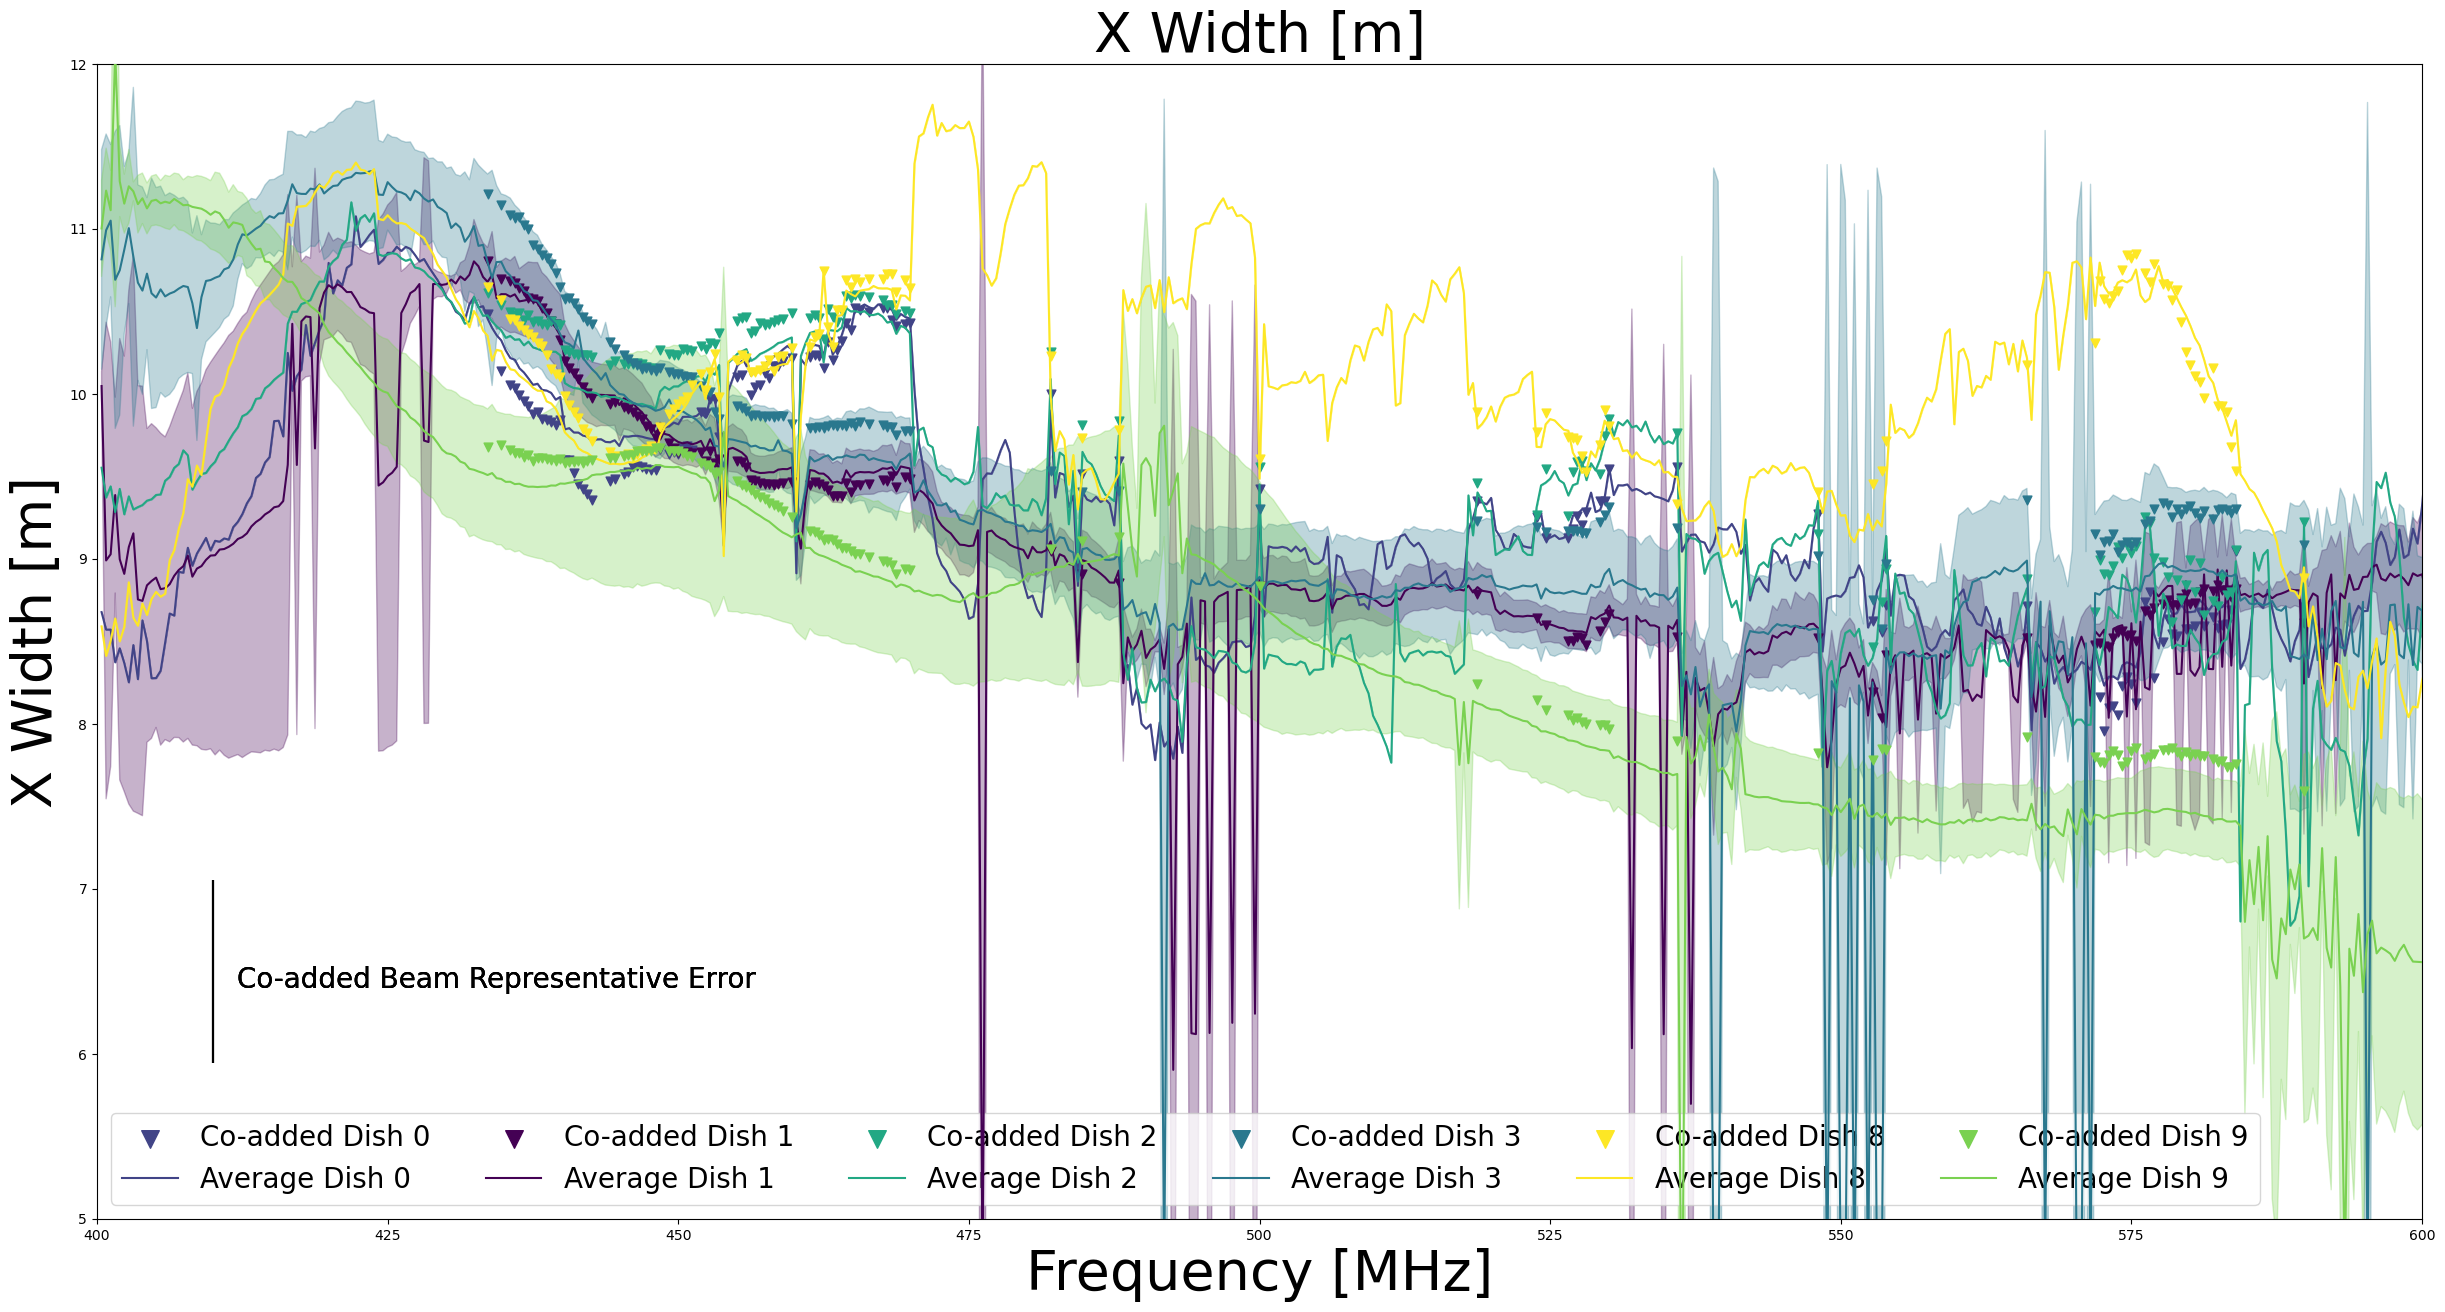

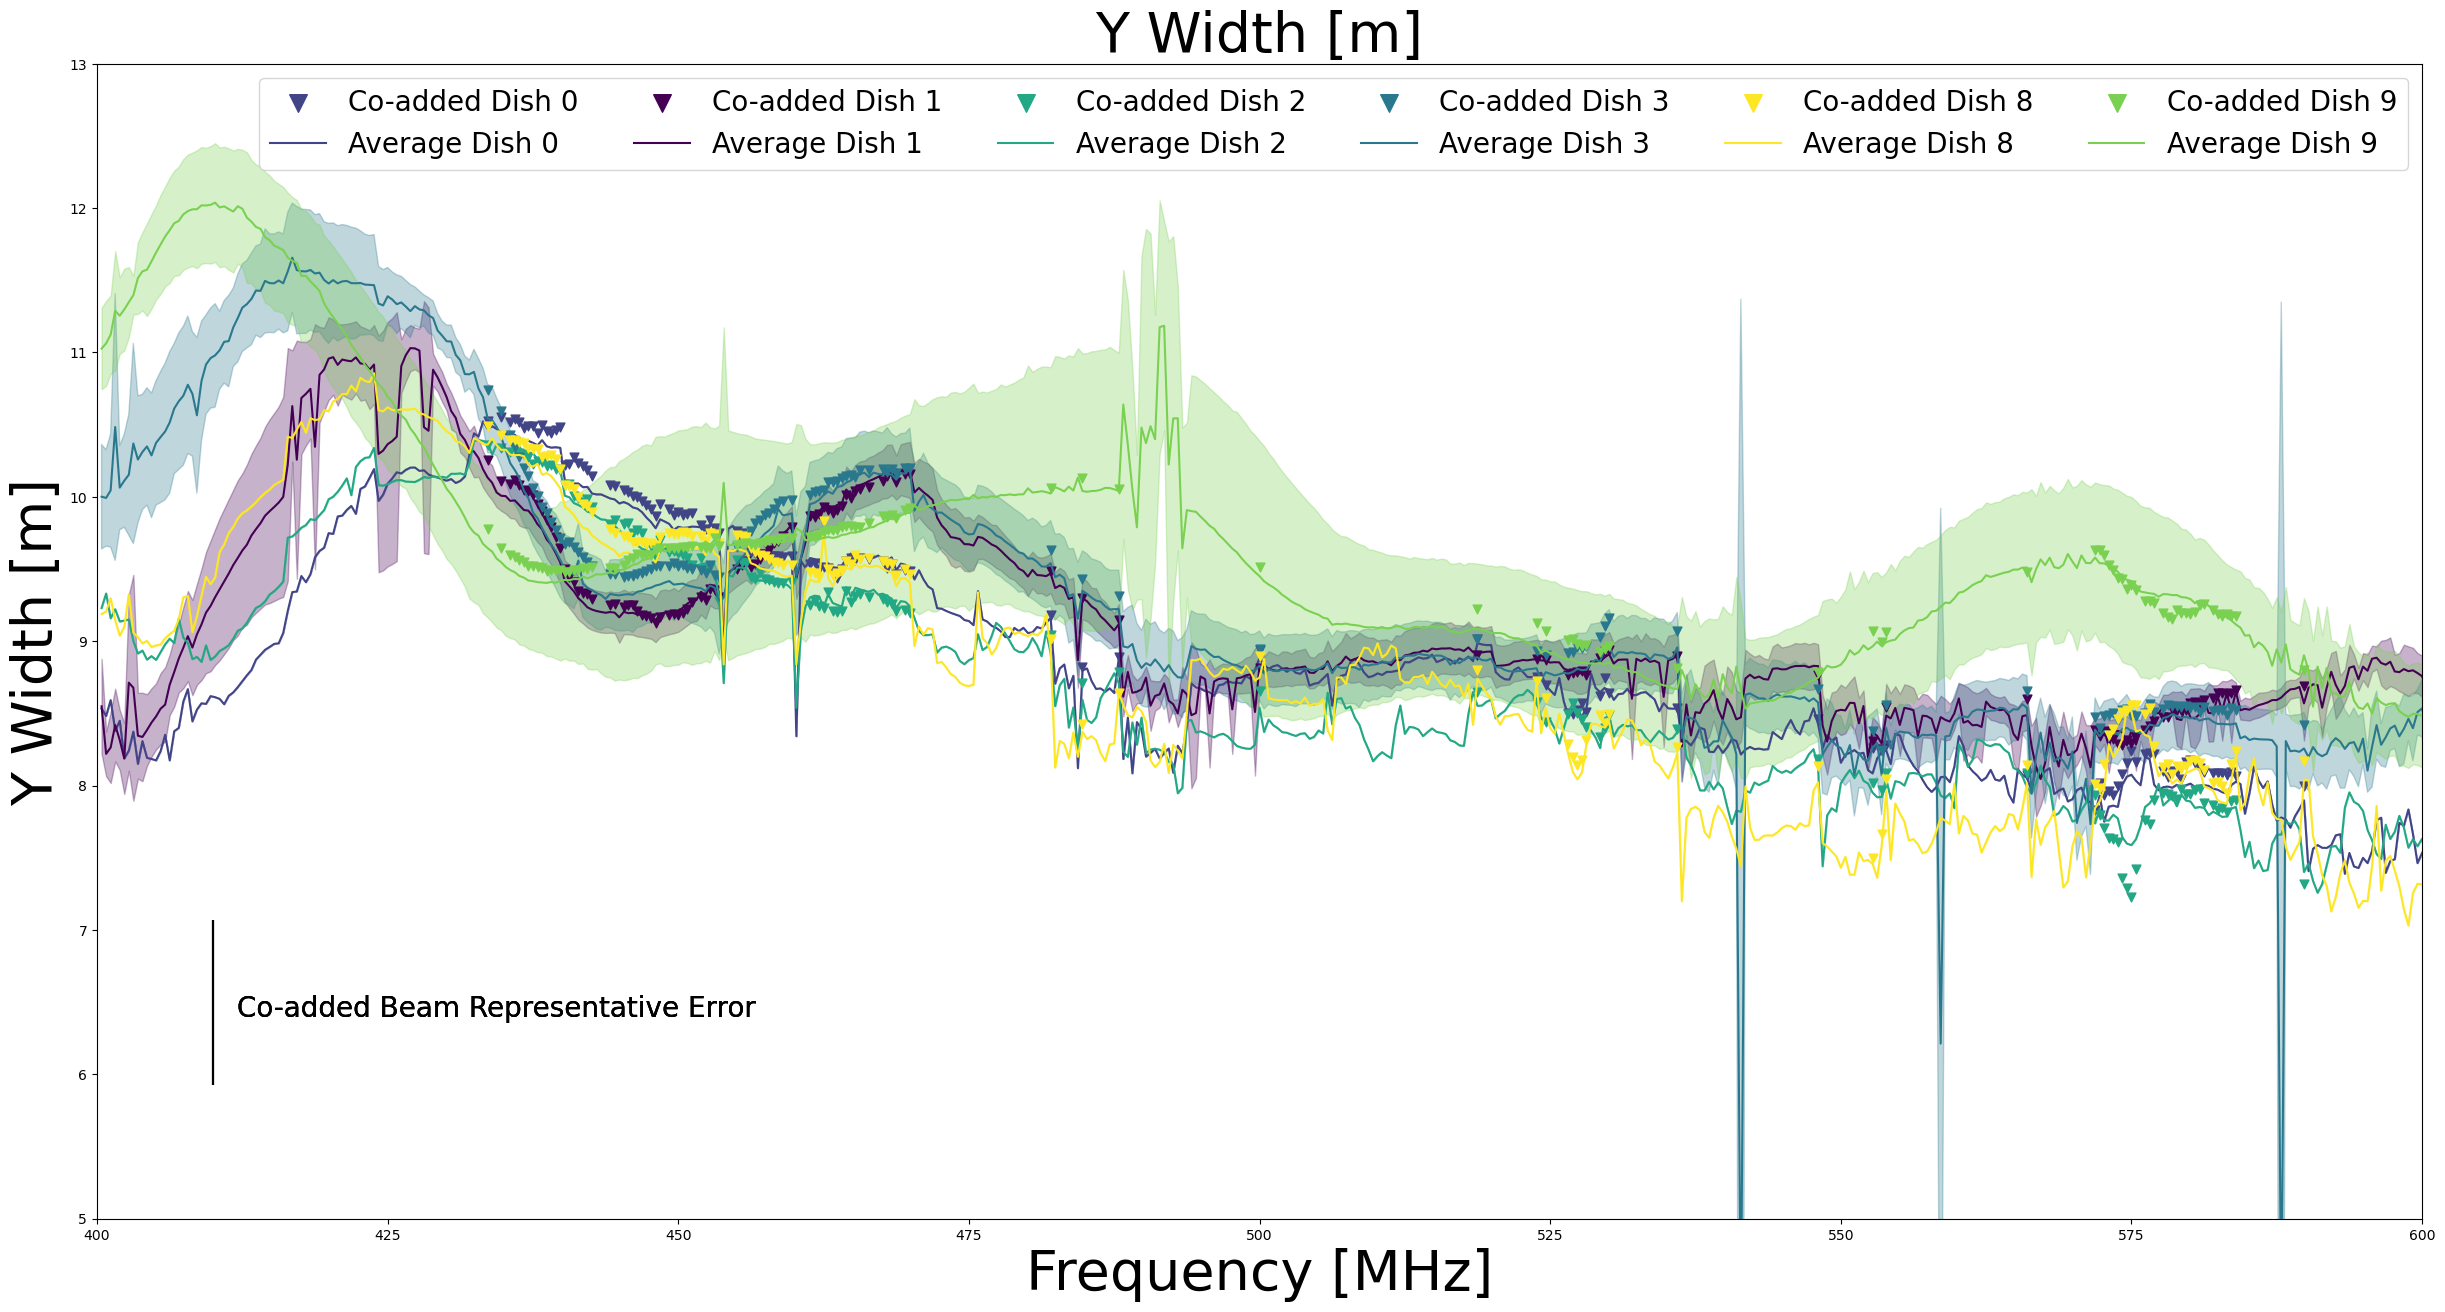

In [7]:
okfreqs = [538, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 
           556,  557,  558,  559,  560,  561,  562,  563,  564,  565,  566,  567,  568,  
     569, 570,  571,  572,  573,  574,  575,  576,  577,  578,  579,  580,  581,  582,  
     583, 584,  599,  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,  
     611, 612,  613,  614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,  
     625, 626,  627,  628,  629,  630,  645,  646,  647,  648,  649,  650,  651,  652,  
     653, 654,  655,  656,  657,  658,  659,  660,  661,  667,  668,  672,  673,  674,  676,
  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,
  691,  692,  693,  694,  695,  696,  697,  698,  699,  700,  701, 702,  703,  704,
  705,  706,  707,  708,  709,  710,  711,  712,  713,  714,  715,  716,  717,  718,
  719,  720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,
  733,  734,  735,  736,  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,
  747,  748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,
  761,  762,  763,  764,  765,  766,  767,  768,  769,  770,  771,  772,  773,  774,
  775,  776,  777,  778,  779,  780,  781,  782,  783,  784,  797,  799,  800,  801,
  802,  803,  804, 805,  806,  807,  809,  810,  811,  812,  813,  814,  815,  816,
  817,  818,  819,  820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,
  831, 832,  833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,  844,
  845,  846,  847,  848,  849,  850,  851,  852,  853,  854,  855,  856,  857,  858,
  859,  860,  861,  862,  863,  864,  865,  866,  867,  868,  871,  872,  873,  874,
  875,  876,  877,  878,  879,  880,  881,  882,  883,  884,  885,  888,  889,  890,
  891,  892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,  903,  904,
  905,  906,  907,  908,  909,  910,  911,  912,  913,  914,  915, 916,  917,  918,
  919,  920,  921,  923,  924,  961,  962,  963,  964,  965,  966,  967,  968,  969,
  970,  971,  972,  973,  974,  976,  977,  978,  984,  991,  994,  995,  996,  997,
  998,  999, 1000, 1001, 1002]


##The Actual Graphs that are Wanted  ####
selectedFlies= ['618','619','625','536']
Npols = [1, 3, 9]
Epols = [0, 2, 8]
colors=pu.cm_to_discrete('viridis', 6)
nC = [colors[0], colors[2], colors[4]]
eC = [colors[1], colors[3], colors[5]]

###widths with dish averages and co-added for dish Eligible Dishes: 0/1, 2/3 8/9 
fig = plt.figure(figsize=(30,15))
for i in range (3):
    plt.errorbar(410, 6.5, yerr=totalSumX, ecolor = 'black')
    plt.text(412, 6.4, 'Co-added Beam Representative Error', fontsize=20)
    plt.fill_between(freqs[cutIndexing], avecoadded['coadded'][Epols[i],cutIndexing,2,0]-avecoadded['coadded'][Epols[i],cutIndexing,2,1], avecoadded['coadded'][Epols[i],cutIndexing,2,0]+avecoadded['coadded'][Epols[i],cutIndexing,2,1], color = eC[i], alpha = 0.3)
    plt.fill_between(freqs[cutIndexing], avecoadded['coadded'][Npols[i],cutIndexing,2,0]-avecoadded['coadded'][Npols[i],cutIndexing,2,1], avecoadded['coadded'][Npols[i],cutIndexing,2,0]+avecoadded['coadded'][Npols[i],cutIndexing,2,1], color = nC[i], alpha = 0.3)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Epols[i],good_freqs,0,2], color=eC[i], marker = 'v', s = 40,label = 'Co-added Dish ' + str(Epols[i]), linestyle = 'None', alpha = 1, zorder=10)
    plt.plot(freqs[cutIndexing], avecoadded['coadded'][Epols[i],cutIndexing,2,0], color=eC[i], label = 'Average Dish ' + str(Epols[i]), alpha = 1, zorder=10)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Npols[i],good_freqs,0,2], color=nC[i], marker = 'v', s = 40, label = 'Co-added Dish ' + str(Npols[i]), linestyle = 'None', alpha = 1, zorder=10)
    plt.plot(freqs[cutIndexing], avecoadded['coadded'][Npols[i],cutIndexing,2,0], color=nC[i], label = 'Average Dish ' + str(Npols[i]), alpha = 1, zorder=10)
plt.title('X Width [m]', fontsize=40)
plt.xlabel('Frequency [MHz]', fontsize=40)
plt.ylabel ('X Width [m]', fontsize=40)
plt.ylim(5,12)
plt.xlim(400,600)
plt.legend(fontsize = 20, ncol=6, markerscale=2)
plt.show()
    

fig = plt.figure(figsize=(30,15))
for i in range (3):
    plt.errorbar(410, 6.5, yerr=totalSumY, ecolor = 'black')
    plt.text(412, 6.4, 'Co-added Beam Representative Error', fontsize=20)
    plt.fill_between(freqs[cutIndexing], avecoadded['coadded'][Epols[i],cutIndexing,4,0]-avecoadded['coadded'][Epols[i],cutIndexing,4,1], avecoadded['coadded'][Epols[i],cutIndexing,4,0]+avecoadded['coadded'][Epols[i],cutIndexing,4,1], color = eC[i], alpha = 0.3)
    plt.fill_between(freqs[cutIndexing], avecoadded['coadded'][Npols[i],cutIndexing,4,0]-avecoadded['coadded'][Npols[i],cutIndexing,4,1], avecoadded['coadded'][Npols[i],cutIndexing,4,0]+avecoadded['coadded'][Npols[i],cutIndexing,4,1], color = nC[i], alpha = 0.3)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Epols[i],good_freqs,0,4], color=eC[i], marker = 'v', s = 40,label = 'Co-added Dish ' + str(Epols[i]), linestyle = 'None', alpha = 1, zorder=10)
    plt.plot(freqs[cutIndexing], avecoadded['coadded'][Epols[i],cutIndexing,4,0], color=eC[i], label = 'Average Dish ' + str(Epols[i]), alpha = 1, zorder=10)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Npols[i],good_freqs,0,4], color=nC[i], marker = 'v', s = 40, label = 'Co-added Dish ' + str(Npols[i]), linestyle = 'None', alpha = 1, zorder=10)
    plt.plot(freqs[cutIndexing], avecoadded['coadded'][Npols[i],cutIndexing,4,0], color=nC[i], label = 'Average Dish ' + str(Npols[i]), alpha = 1, zorder=10)
plt.title('Y Width [m]', fontsize=40)
plt.xlabel('Frequency [MHz]', fontsize=40)
plt.ylabel ('Y Width [m]', fontsize=40)
plt.ylim(5,13)
plt.xlim(400,600)
plt.legend(fontsize = 20, ncol=6, markerscale=2)
plt.show()



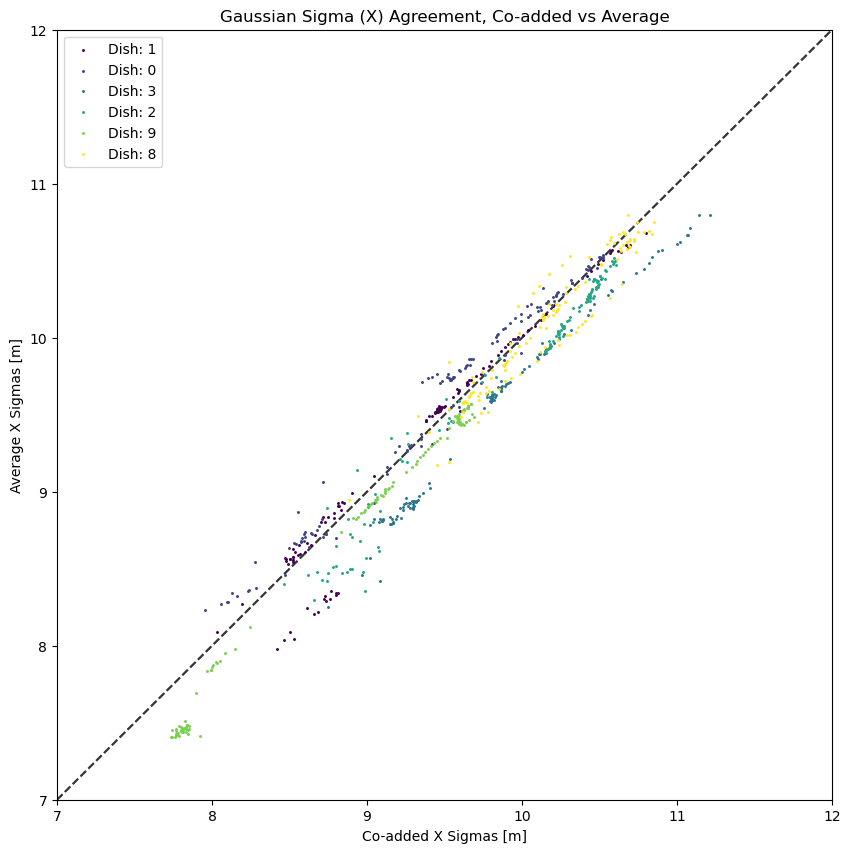

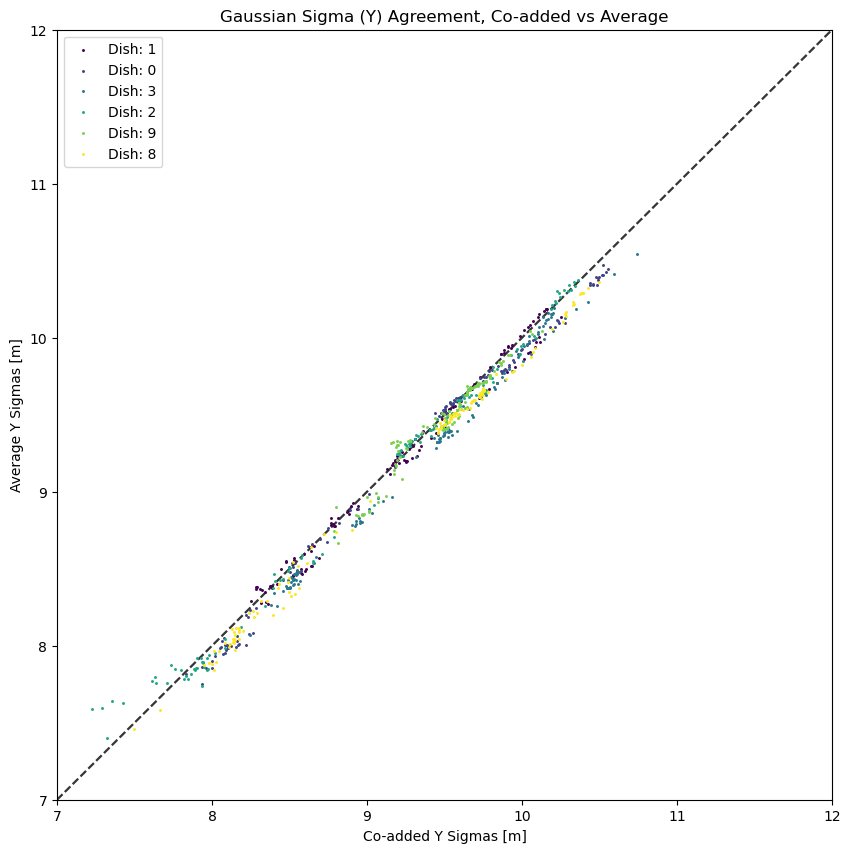

In [8]:
colors=pu.cm_to_discrete('viridis', 6)
nC = [colors[0], colors[2], colors[4]]
eC = [colors[1], colors[3], colors[5]]
fig = plt.figure(figsize=(10,10))

for i in range (3):
    plt.scatter(coadded['G_popt_w_errors'][Npols[i],good_freqs,0,2], avecoadded['coadded'][Npols[i],good_freqs,2,0],marker='.', s=5, color = nC[i], linestyle='None', zorder=10, label = 'Dish: ' + str(Npols[i]))
    plt.scatter(coadded['G_popt_w_errors'][Epols[i],good_freqs,0,2], avecoadded['coadded'][Epols[i],good_freqs,2,0],marker='.', s=5, color = eC[i], linestyle='None', zorder=10, label = 'Dish: ' + str(Epols[i]))
    plt.plot([7,8,9,10,11,12],[7,8,9,10,11,12], color = 'black',linestyle = 'dashed', alpha = 0.4)
plt.title('Gaussian Sigma (X) Agreement, Co-added vs Average')
plt.xlabel('Co-added X Sigmas [m]')
plt.ylabel('Average X Sigmas [m]')
plt.xlim(7,12)
plt.ylim(7,12)
plt.show
plt.legend()

fig = plt.figure(figsize=(10,10))
for i in range (3):
    plt.scatter(coadded['G_popt_w_errors'][Npols[i],good_freqs,0,4], avecoadded['coadded'][Npols[i],good_freqs,4,0],marker='.', s=5, color = nC[i], linestyle='None', zorder=10, label = 'Dish: ' + str(Npols[i]))
    plt.scatter(coadded['G_popt_w_errors'][Epols[i],good_freqs,0,4], avecoadded['coadded'][Epols[i],good_freqs,4,0],marker='.', s=5, color = eC[i], linestyle='None', zorder=10, label = 'Dish: ' + str(Epols[i]))
    plt.plot([7,8,9,10,11,12],[7,8,9,10,11,12], color = 'black',linestyle = 'dashed', alpha = 0.4)
plt.title('Gaussian Sigma (Y) Agreement, Co-added vs Average')
plt.xlabel('Co-added Y Sigmas [m]')
plt.ylabel('Average Y Sigmas [m]')
plt.xlim(7,12)
plt.ylim(7,12)
plt.show
plt.legend()


In [ ]:
#Code that develops the fitting params for the range restricted and nonrange restricted functions 
amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
print(beamdir)
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])

valArrayX=np.zeros([len(good_freqs), 2])
valArrayY=np.zeros([len(good_freqs), 2])
errorArrayX=np.zeros([len(good_freqs), 2])
errorArrayY=np.zeros([len(good_freqs), 2])

for j, chind in enumerate(good_freqs): 
    droneData = readPickleFile ('N', j)
    mbx = droneData.x_centers_grid[:,:,0].flatten()
    mby = droneData.y_centers_grid[:,:,0].flatten()
    mbV = droneData.V_LC_operation[:,:,0,1].flatten()
    good_data = np.isfinite(mbV)
    gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < 25) & (np.abs(mby) < 25))[0]
    gi = np.where(np.isfinite(mbV))[0]
    input_data_rest=np.array([mbx[gi],mby[gi],mbV[gi]])
    input_data=np.array([mbx[good_data], mby[good_data], mbV[good_data]])
    G_popt_rest = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf', args=input_data_rest)
    G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
    valArrayX[j][0]=G_popt_rest.x[2]  
    valArrayX[j][1]=G_popt.x[2]  
    valArrayY[j][0]=G_popt_rest.x[4]  
    valArrayY[j][1]=G_popt.x[4]  
    cov_matrix_rest = G_popt_rest.jac.T @G_popt_rest.jac
    param_errors_rest = np.sqrt(np.diag(cov_matrix_rest))
    cov_matrix = G_popt.jac.T @G_popt.jac
    param_errors = np.sqrt(np.diag(cov_matrix))
    errorArrayX[j, 0]=param_errors_rest[2]
    errorArrayX[j, 1]=param_errors[2]
    errorArrayY[j, 0]=param_errors_rest[4]
    errorArrayY[j, 1]=param_errors[4]

fig = plt.figure(figsize=(10,10))
plt.errorbar(valArrayX[:,0], valArrayX[:,1],yerr=errorArrayX[:,0],
                 marker='.', color = '#35b779', linestyle='None')
plt.plot([7,12.5], [7,12.5], linestyle="dashed", color = '#fde725')
plt.title('Gaussian Sigma (X) Agreement with Error Dish 1')
plt.xlabel('Range Restricted (20) X Sigmas [m]')
plt.ylabel('Non Restricted X Sigmas [m]')
plt.xlim(7,12)
plt.ylim(7,12)

fig = plt.figure(figsize=(10,10))
plt.errorbar(valArrayY[:,0], valArrayY[:,1],yerr=errorArrayY[:,0],
                 marker='.',color = '#440154', linestyle='None')
plt.plot([7.5,11], [7.5,11], linestyle="dashed", color = '#31688e')
plt.title('Gaussian Sigma (Y) Agreement with Error Dish 1')
plt.xlabel('Range Restricted (20) Y Sigmas [m]')
plt.ylabel('Non Restricted Y Sigmas [m]')
plt.ylim(7.5,11)
plt.xlim(7.5,11)

In [ ]:
#graphinng just dish zero / one 
selectedFlies= ['618','619','625','536']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (15,10))
aveNorthSigArray=np.zeros((2,len(good_freqs)))
colors = ['#fde725','#5ec962','#21918c','#3b528b','#440154']
fig, ax2 = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (15,10))
for f in range(0,len(selectedFlies)):
    fly = selectedFlies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    ax[0].scatter(freqs[good_freqs],fits['G_popt'][1,good_freqs,2], s=1, color=colors[f],linestyle='None', label = fly)
    ax[1].scatter(freqs[good_freqs],fits['G_popt'][1,good_freqs,4], s=1, color=colors[f],linestyle='None', label = fly)
    ax2[0].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][1,good_freqs,2], coadded['G_popt_w_errors'][Npols[0],good_freqs,0,2]), s=1, color=colors[f],linestyle='None', label = fly)
    ax2[1].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][1,good_freqs,4], coadded['G_popt_w_errors'][Npols[0],good_freqs,0,4]), s=1, color=colors[f],linestyle='None', label = fly)
fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits = np.load(ffile)

ax[0].scatter(freqs[good_freqs],fits['G_popt'][0,good_freqs,2], s=1, color=colors[4],linestyle='None', label = fly)
ax[1].scatter(freqs[good_freqs],fits['G_popt'][0,good_freqs,4], s=1, color=colors[4],linestyle='None', label = fly)
ax2[0].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][0,good_freqs,2],coadded['G_popt_w_errors'][Epols[0],good_freqs,0,2]), s=1, color=colors[4],linestyle='None', label = fly)
ax2[1].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][0,good_freqs,4],coadded['G_popt_w_errors'][Epols[0],good_freqs,0,2]), s=1, color=colors[4],linestyle='None', label = fly)
ax[0].scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Npols[0],good_freqs, 0, 2], s=3, color = 'black', marker='o', label = 'Co-added N')
ax[1].scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Npols[0], good_freqs, 0, 4], s=3, color = 'black', marker='o', label = 'Co-added N')
ax[0].scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Epols[0], good_freqs, 0, 2], s=1, color = 'grey', zorder=2, marker='o', label = 'Co-added E')
ax[1].scatter(freqs[good_freqs], coadded['G_popt_w_errors'][Epols[0], good_freqs, 0, 4], s=1, color = 'grey', zorder=2, marker='o', label = 'Co-added E')
ax[0].set_ylim(0,12.5)
ax[1].set_ylim(0,12.5)
ax[0].set_title('X Width [m]')
ax[1].set(xlabel = 'Frequency [MHz]', ylabel = 'Y Width [m]')
ax[1].set_title('Y Width [m]')
ax[0].set(ylabel = 'X Width [m]')
ax2[0].set_title('X Width Differences [m]')
ax2[1].set(xlabel = 'Frequency [MHz]', ylabel = 'Y Width Differences [m]')
ax2[0].set(ylabel = 'X Width Differences [m]')
ax2[1].set_title('Y Width Differences [m]')
ax[1].legend()
ax[0].legend()
ax2[0].legend()
ax2[1].legend()




In [ ]:
#identiyfing the bad frequencies in flight 625: 
ffile = glob.glob(fitdir+'*'+'625'+'*')[0]
fits = np.load(ffile)


for i in range (len(good_freqs)):
    if (fits['G_popt'][1,good_freqs[i], 2] < 7): 
        print ('Bad Frequency: ' + str(freqs[good_freqs[i]]) + ' Bad Index: ' + str(good_freqs[i]))   


In [ ]:
#something is wrong with this again 

amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0


lowFreq = turnPickle ('625', 1)
highFreq = turnPickle ('625', 2)

#redefine low and high frequencies here 

pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
mbxlow = lowFreq.x_centers_grid[:,:,0].flatten()
mbylow = lowFreq.y_centers_grid[:,:,0].flatten()
mbVlow = lowFreq.V_LC_operation[:,:,0,1].flatten()
mbxHigh = higherFreq.x_centers_grid[:,:,0].flatten()
mbyHigh = higherFreq.y_centers_grid[:,:,0].flatten()
mbVHigh = higherFreq.V_LC_operation[:,:,0,11].flatten()
gooddatalow = np.isfinite(mbVlow)
gooddataHigh = np.isfinite(mbVHigh)
input_data_l=np.array([mbxlow[gooddatalow],mbylow[gooddatalow],mbVlow[gooddatalow]])
input_data_h=np.array([mbxHigh[gooddataHigh],mbyHigh[gooddataHigh],mbVHigh[gooddataHigh]])
G_popt_l=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data_l).x
G_popt_h=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data_h).x

gaussL= gaussianResultArray(G_popt_l, mbxlow, mbylow)
guassH= gaussianResultArray(G_popt_h, mbxHigh, mbyHigh)

#Plotting an Horizontal Slice 
horizontalGaussSliceL = getSliceGauss(gaussL, 'h')
horizontalGaussSliceH = getSliceGauss(guassH, 'h')
horizontalIndexL = get_slice(lowFreq,lowFreq.V_LC_operation[:,:,0,11],1.25,'h')
horizontalIndexH = get_slice(higherFreq,higherFreq.V_LC_operation[:,:,0,11],1.25,'h')
fig = plt.figure(figsize=(15,10))
plt.scatter(lowFreq.x_centers_grid[:,horizontalIndexL[0],0],lowFreq.V_LC_operation[:,horizontalIndexL[0],0,11], c = 'blue', label = 'Data 589.84375 Wierd', marker = 'x', alpha = 0.5 )
plt.scatter(higherFreq.x_centers_grid[:,horizontalIndexH[0],0],higherFreq.V_LC_operation[:,horizontalIndexH[0],0,11], c = 'black', label ='Data 583.984375', marker = '+', alpha = 0.5)
plt.scatter(horizontalGaussSliceL[0, :], horizontalGaussSliceL[2, :], c = 'red', label = 'Fit 589.84375 Weird')
plt.scatter(horizontalGaussSliceH[0, :], horizontalGaussSliceH[2, :], c = 'green', label ='Fit 583.984375')
plt.title('Input Y = 1.25')
plt.ylim(-1,1.5)
plt.xlim(-20,20)
plt.legend()
plt.show()

In [ ]:
print (np.where(freqs == 583.984375))
print (np.where(freqs == 589.84375))
print (np.where(good_freqs == 553))
print (np.where(good_freqs == 538))

print (good_freqs)

In [ ]:
#add the dish 11 and fourteen slicing here 

In [ ]:
fits = np.load('/hirax/GBO_Analysis_Outputs/main_beam_fits/Coadded_2dGauss_and_Airy_Params.npz')
pols = N_pols
fig = plt.figure(figsize=(10,10))
x = 0
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
    plt.plot(freqs[good_freqs], coadded['G_popt_w_errors'][pp,good_freqs,0,2], marker = 'x', label = 'Js: ' + str(pp), linestyle = 'None')
    x = x + 1
plt.ylabel('X width')
plt.legend()
plt.show()
x = 0
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
    plt.plot(freqs[good_freqs], coadded['G_popt_w_errors'][pp,good_freqs,0,4], marker = 'x', label = 'Js: ' + str(pp), linestyle = 'None')
    x = x + 1
plt.ylabel('Y width')
plt.legend()
plt.show()
pols = E_pols
x = 0
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
    plt.plot(freqs[good_freqs], coadded['G_popt_w_errors'][pp,good_freqs,0,2], marker = 'x', label = 'Js: ' + str(pp), linestyle = 'None')
    x = x + 1
plt.ylabel('X width')
plt.legend()
plt.show()
x = 0
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
    plt.plot(freqs[good_freqs], coadded['G_popt_w_errors'][pp,good_freqs,0,4], marker = 'x', label = 'Js: ' + str(pp), linestyle = 'None')
    x = x + 1
plt.ylabel('Y width')
plt.legend()
plt.show()
fig = plt.figure(figsize=(10,10))
for p, pp in enumerate (pols):
    plt.plot(freqs[good_freqs], coadded['G_popt_w_errors'][pp,good_freqs,0,4], marker = 'x', label = 'Js: ' + str(pp), linestyle = 'None')

# Finding the mean, median, and standard deviation of the altitudes of each flight: 

In [ ]:
#The net ID in the file name must be modified to whoever's is trying to run this code or permission will be denied :) 
f = -1
with open('/home/jad283/newburghlabdrone/analysis/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fly in flights:
    print('THIS FLIGHT! ',fly)
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

    fly = flights[f]
    tub = documents["flight_info"]["tubs"][f]
    tlb = documents["flight_info"]["tlbs"][f]
    cdat = documents["flight_info"]["cdats"][f]
    tclb = documents["flight_info"]["tclbs"][f]
    tcub = documents["flight_info"]["tcubs"][f]
    fmax = documents["flight_info"]["fmaxes"][f]

    if int(fly) < 537:
        mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
        gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
    else:
        mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
        gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

    sdir = os.listdir(mdir)[0]
    datadir=mdir+sdir+'/'
    print(sdir, datadir,gaindir)
    
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

    print('DONE reading in drone data')
    print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])

    pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])
    #pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[2400,10200])

    print(np.median(dronetest0825.altitude))
    print(np.mean(dronetest0825.altitude))
    print(np.std(dronetest0825.altitude))
    # in m

In [ ]:
# Plot slices
# MAPPS ::: take slice at x = 0

amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])

for i, frequency in enumerate(good_freqs):
    ptest = readPickleFile('N', i)
    mbx = ptest.x_centers_grid[:,:,0].flatten()
    mby = ptest.y_centers_grid[:,:,0].flatten()
    mbV = ptest.V_LC_operation[:,:,0,11].flatten()
    gaussianEstimateArray = gaussianResultArray (coadded['G_popt_w_errors'][11,good_freqs[i],0,:], mbx, mby)
    #Plotting an Horizontal Slice 
    horizontalGaussSlice = getSliceGauss(gaussianEstimateArray, 'h')
    horizontalIndex = get_slice(ptest,ptest.V_LC_operation[:,:,0,11],1.25,'h')
    fig = plt.figure(figsize=(15,10))
    plt.yscale('log')
    plt.scatter(ptest.x_centers_grid[:,horizontalIndex[0],0],ptest.V_LC_operation[:,horizontalIndex[0],0,11], c = 'black')
    #plt.scatter(horizontalGaussSlice[0, :], horizontalGaussSlice[2, :], c = 'red')
    plt.title('Input X = 1.25, '+ 'Frequency: ' + str(freqs[good_freqs[i]]))
    plt.xlabel('Y [m]')
    plt.ylim(-1,1)
    plt.xlim(-1*sz,sz)
    plt.legend()
    plt.show()
    
    verticalIndex = get_slice(ptest,ptest.V_LC_operation[:,:,0,11],1.25,'v')
    verticalGaussSlice = getSliceGauss(gaussianEstimateArray, 'v')                                                              
    #Plotting a vertical slice 
    fig = plt.figure(figsize=(15,10))
    plt.yscale('log')
    plt.scatter(ptest.y_centers_grid[verticalIndex[0],:,0],ptest.V_LC_operation[verticalIndex[0],:,0,11], c = 'black')
   # plt.scatter(verticalGaussSlice[1, :], verticalGaussSlice[2, :], c = 'green')
    plt.ylim(-1,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input Y = 1.25, '+ 'Frequency: ' + str(freqs[good_freqs[i]]))
    plt.xlabel('X [m]')
    plt.xlabel('Frequency MHz')
    plt.legend()
    plt.show()

In [ ]:
################################################################################################
################# 3. Compare to the combination of individual flights #####################
################################################################################################

## N pol flights

flies = ['618','619','625','536','646', '647','533']
pols = N_pols
markers = ['s','v','^','>','P','x','+','o']
colors = colors=pu.cm_to_discrete('viridis', 7)
p = 0

for i in range (5):
    # X width
    fig = plt.figure(figsize=(8,6), dpi = 1200)
    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][polsN[i],:,2], color=colors[f], label=fly, zorder=1, linewidth = 1)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][polsN[i],good_freqs,0,2], s=7, color = 'grey', zorder=10, label = "Co-added", edgecolor ='black', linewidth = 0.1)
    plt.title('X width [m] Dish ' + str (polsN[i]))
    plt.legend()
    plt.ylim(4,18)
    plt.xlabel('Frequency MHz')
    plt.ylabel('X Sigmas [m]')
    plt.show()

# Y width
for i in range (5):
    fig = plt.figure(figsize=(8,6), dpi =1200)
    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][polsN[i],:,4],color=colors[f], label=fly, zorder=1, linewidth = 1)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][polsN[i],good_freqs,0,4], s=7, color = 'grey', zorder=10, label = "Co-added", edgecolor ='black', linewidth = 0.1)
    plt.title('Y width [m] Dish ' + str (polsN[i]))
    plt.legend()
    plt.xlabel('Frequency MHz')
    plt.ylabel('Y Sigmas [m]')
    plt.ylim(4,18)
    plt.show()
    
    
# E pol flights

flies = ['620','648','649','535']
pols = E_pols
markers = ['s','v','^','>']
colors=colors = colors=pu.cm_to_discrete('viridis', 4)
p = 0

for i in range (5):
    # X width
    fig = plt.figure(figsize=(8,6), dpi =1200)
    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][polsE[i],:,2], color=colors[f], label=fly, zorder=1, linewidth = 1)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][polsE[i],good_freqs,0,2], s=7, color = 'grey', zorder=10, label = "Co-added", edgecolor ='black', linewidth = 0.1)
    plt.title('X width [m] Dish ' + str (polsE[i]))
    plt.legend()
    plt.ylim(4,18)
    plt.xlabel('Frequency MHz')
    plt.ylabel('X Sigmas [m]')
    plt.show()

# Y width
for i in range (5):
    fig = plt.figure(figsize=(8,6), dpi =1200)
    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][polsE[i],:,4],color=colors[f], label=fly, zorder=1, linewidth = 1)
    plt.scatter(freqs[good_freqs], coadded['G_popt_w_errors'][polsE[i],good_freqs,0,4], s=7, color = 'grey', zorder=10, label = "Co-added", edgecolor ='black', linewidth = 0.1)
    plt.title('Y width [m] Dish ' + str (pols[i]))
    plt.legend()
    plt.ylim(4,18)
    plt.xlabel('Frequency MHz')
    plt.ylabel('Y Sigmas [m]')
    plt.show()   